## API calls

In [4]:
'''
*Version: 2.0 Published: 2021/03/09* Source: [NASA POWER](https://power.larc.nasa.gov/)
POWER API Multi-Point Download
This is an overview of the process to request data from multiple data points from the POWER API.
'''

import os, json, requests

locations = [(32.929, -95.770), (5, 10)]

output = r""
base_url = r"https://power.larc.nasa.gov/api/temporal/daily/point?parameters=T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN&community=RE&longitude={longitude}&latitude={latitude}&start=20150101&end=20150105&format=JSON"

for latitude, longitude in locations:
    api_request_url = base_url.format(longitude=longitude, latitude=latitude)

    response = requests.get(url=api_request_url, verify=True, timeout=30.00)

    content = json.loads(response.content.decode('utf-8'))
    filename = response.headers['content-disposition'].split('filename=')[1]

    filepath = os.path.join(output, filename)
    with open(filepath, 'w') as file_object:
        json.dump(content, file_object)

In [5]:
content

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [10.0, 5.0, 776.92]},
 'properties': {'parameter': {'T2M': {'20150101': 22.77,
    '20150102': 22.12,
    '20150103': 22.08,
    '20150104': 20.98,
    '20150105': 21.37},
   'T2MDEW': {'20150101': 16.76,
    '20150102': 14.47,
    '20150103': 14.52,
    '20150104': 12.67,
    '20150105': 14.3},
   'T2MWET': {'20150101': 19.76,
    '20150102': 18.3,
    '20150103': 18.3,
    '20150104': 16.83,
    '20150105': 17.83},
   'TS': {'20150101': 22.2,
    '20150102': 21.49,
    '20150103': 21.19,
    '20150104': 20.24,
    '20150105': 20.1},
   'T2M_RANGE': {'20150101': 12.09,
    '20150102': 13.99,
    '20150103': 11.15,
    '20150104': 13.3,
    '20150105': 12.2},
   'T2M_MAX': {'20150101': 29.64,
    '20150102': 29.33,
    '20150103': 28.23,
    '20150104': 28.11,
    '20150105': 27.38},
   'T2M_MIN': {'20150101': 17.55,
    '20150102': 15.34,
    '20150103': 17.08,
    '20150104': 14.8,
    '20150105': 15.19}}},
 'header': 

## Parameters used by Holos for precipitation and evapotranspiration:

1. `PRECTOTCORR`:
- **Name**: Precipitation Corrected
    -  The bias corrected average of total precipitation at the surface of the earth in water mass (includes water content in snow).  


- **Statistics Available**
  - CLIMATOLOGY, MONTHLY, DAILY, HOURLY


- **Units Available**
  - Agroclimatology: mm/day
  - Sustainable Buildings: mm/day
  - Renewable Energy: mm/day

2. `T2M`
- **Name**: Temperature at 2 Meters
    - The average air (dry bulb) temperature at 2 meters above the surface of the earth.
       
- **Statistics Available**
  - CLIMATOLOGY, MONTHLY, DAILY, HOURLY
    
- **Units Available**
  - Agroclimatology: C
  - Sustainable Buildings: C
  - Renewable Energy: C

3. `RH2M`
- **Name**: Relative Humidity at 2 Meters
  - The ratio of actual partial pressure of water vapor to the partial pressure at saturation, expressed in percent.  
 
- **Statistics Available**
  - CLIMATOLOGY, MONTHLY, DAILY, HOURLY
    
- **Units Available**
  - Agroclimatology: %
  - Sustainable Buildings: %
  - Renewable Energy: %

4. `ALLSKY_SFC_SW_DWN`
- **Name**: All Sky Surface Shortwave Downward Irradiance
    - The total solar irradiance incident (direct plus diffuse) on a horizontal plane at the surface of the earth under all sky conditions. An alternative term for the total solar irradiance is the "Global Horizontal Irradiance" or GHI.

- Statistics Available:
  - CLIMATOLOGY, MONTHLY, DAILY, HOURLY
 
- Units Available
    - **Agroclimatology: MJ/m^2/day**
    - Sustainable Buildings: W/m^2
    - Renewable Energy: kW-hr/m^2/day 


## Calculating evapotranspiration

In [5]:
def calculate_reference_evapotranspiration(mean_daily_temperature, solar_radiation, relative_humidity):
    """
    Calculate reference evapotranspiration (mm day^-1) using the given
    mean daily temperature (C), solar radiation (MJ m^-2 day^-1),
    and relative humidity (%).

    Parameters:
    mean_daily_temperature (float): Mean daily temperature in Celsius (C).
    solar_radiation (float): Solar radiation in MJ m^-2 day^-1.
    relative_humidity (float): Relative humidity in percent (%).

    Returns:
    float: Reference evapotranspiration in mm day^-1.
    """
    # Holos Technical Report, Page 22:
        # Eq. 1.6.2-1
        # Eq. 1.6.2-2
            # Turc equation
    # Holos Github code:
        # https://github.com/holos-aafc/Holos/blob/afb61d2fe38e62a818c8b5932d308497da12a5da/H.Core/Calculators/Climate/EvapotranspirationCalculator.cs
    
    term1 = 0.013

    # Return 0 evapotranspiration if temperature is <= 0
    if mean_daily_temperature <= 0:
        return 0

    # Avoid division by zero if temperature exactly -15 degrees Celsius
    if abs(mean_daily_temperature + 15) < 1e-10:
        return 0

    term2 = mean_daily_temperature / (mean_daily_temperature + 15)
    term3 = (23.8856 * solar_radiation) + 50
    term4 = 1 + ((50 - relative_humidity) / 70)

    if relative_humidity >= 50:
        result = term1 * term2 * term3
    else:
        result = term1 * term2 * term3 * term4

    # Ensure evapotranspiration is not negative
    if result < 0:
        return 0

    return result

# Example usage
et = calculate_reference_evapotranspiration(20, 5, 45)
print(f"Reference Evapotranspiration: {et} mm/day")


Reference Evapotranspiration: 1.3485085714285712 mm/day


## Exploring how climate data is used in N2O emission factor calculation

In Holos/H.Content/CsvResourceReader.cs 

```
case CsvResourceNames.EcodistrictToEcozoneMapping:
return SplitFileIntoLines(Resource.ecodistrict_to_ecozone_mapping);

case CsvResourceNames.ClimateNormalsByPolygon1950_1980:
    return SplitFileIntoLines(Resource.climateNorms_by_poly_1950_1980);

case CsvResourceNames.ClimateNormalsByPolygon1960_1990:
    return SplitFileIntoLines(Resource.climateNorms_by_poly_1960_1990);

case CsvResourceNames.ClimateNormalsByPolygon1970_2000:
    return SplitFileIntoLines(Resource.climateNorms_by_poly_1970_2000);

case CsvResourceNames.ClimateNormalsByPolygon1980_2010:
    return SplitFileIntoLines(Resource.climateNorms_by_poly_1980_2010);

case CsvResourceNames.ClimateNormalsByPolygon1990_2017:
    return SplitFileIntoLines(Resource.climateNorms_by_poly_1990_2017);
```

Then In `Holos/H.Core/Providers/Soil/EcodistrictDefaultsProvider.cs`
https://github.com/holos-aafc/Holos/blob/afb61d2fe38e62a818c8b5932d308497da12a5da/H.Core/Providers/Soil/EcodistrictDefaultsProvider.cs

`var fileLines = CsvResourceReader.GetFileLines(CsvResourceNames.EcodistrictToEcozoneMapping);`

```
            {
                var ecodistrictId = int.Parse(line[0], cultureInfo);
                var ecozone = _ecozoneStringConverter.Convert(line[1]);
                var province = _provinceStringConverter.Convert(line[2]);
                var pMayToOct = int.Parse(line[3], cultureInfo);
                var peMayToOct = int.Parse(line[4], cultureInfo);
                var fTopo = double.Parse(line[5], cultureInfo);
                var soilType = _soilFunctionalCategoryStringConverter.Convert(line[6]);
                var soilTexture = _soilTextureStringConverter.Convert(line[7]);

                results.Add(new EcodistrictDefaultsData()
                {
                    EcodistrictId = ecodistrictId,
                    Ecozone = ecozone,
                    Province = province,
                    PMayToOct = pMayToOct,
                    PEMayToOct = peMayToOct,
                    FTopo = fTopo,
                    SoilFunctionalCategory = soilType,
                    SoilTexture = soilTexture,
                });
            }

```

```
            if (result != null)
            {
                // Convert value to a fraction not a percentage (i.e. 0.20 not 20)
                return result.FTopo / 100;
            }
            else
            {
                Trace.TraceError($"{nameof(EcodistrictDefaultsProvider)}.{nameof(EcodistrictDefaultsProvider.GetEcozone)} unable to get FTopo value for ecodistrict: {ecodistrictId}. Returning default value of {defaultValue}.");

                return defaultValue;
            }
        }
```

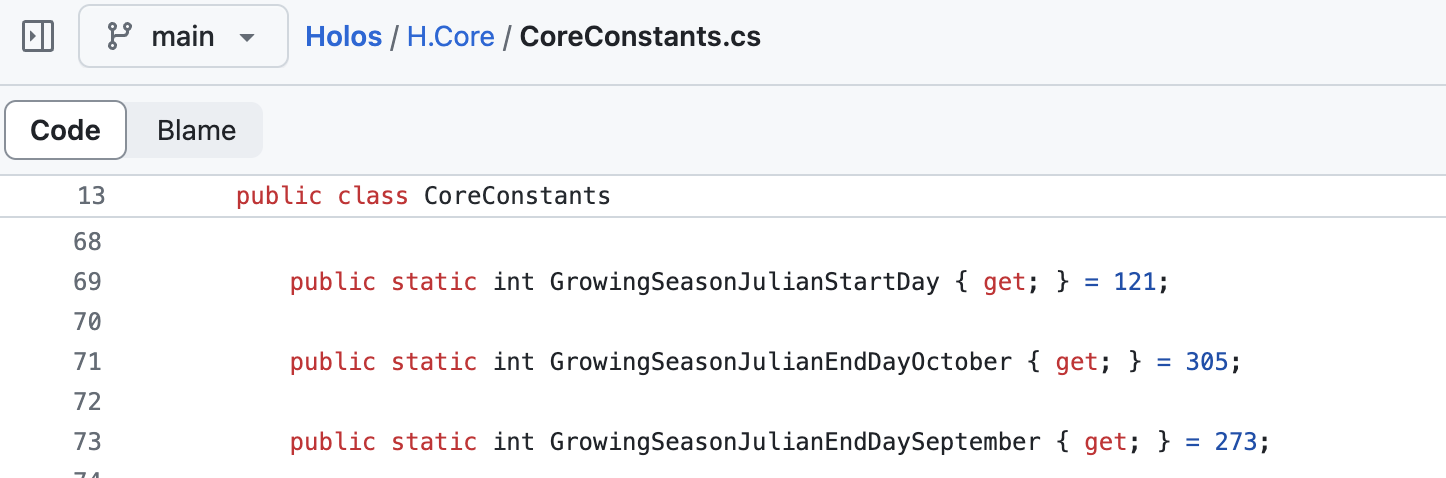

In [13]:
import requests
import json
from datetime import datetime
from evapotranspiration_calculator import EvapotranspirationCalculator

def fetch_growing_season_data(latitude, longitude, year):
    """
    Fetch growing season data from NASA POWER API and calculates total evapotranspiration.

    Parameters:
        latitude (float): Latitude of the location.
        longitude (float): Longitude of the location.
        year (int): Year for which data is requested.

    Returns:
        dict: Dictionary containing total precipitation, total evapotranspiration, and other parameters.
    """
    start_date = f"{year}0501"  # May 1st
    end_date = f"{year}0930"    # September 30th

    # Define the parameters and the community
    parameters = "PRECTOTCORR,T2M,RH2M,ALLSKY_SFC_SW_DWN"
    community = "AG"

    # Construct the API request URL
    base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    api_request_url = (
        f"{base_url}?parameters={parameters}&community={community}"
        f"&longitude={longitude}&latitude={latitude}&start={start_date}&end={end_date}&format=JSON"
    )

    # Make the API request
    response = requests.get(api_request_url, timeout=30.00)
    if response.status_code != 200:
        raise Exception("Failed to fetch data from NASA POWER API")

    # Load JSON response content
    data = json.loads(response.content.decode('utf-8'))
    
    # Initialize variables to store total precipitation and other data
    total_precipitation = 0
    total_evapotranspiration = 0

    # Extract data for each day in the response
    for day in data['properties']['parameter']['PRECTOTCORR']:
        total_precipitation += data['properties']['parameter']['PRECTOTCORR'][day]
        
        # Initialize EvapotranspirationCalculator with daily values
        calculator = EvapotranspirationCalculator(
            mean_daily_temperature=data['properties']['parameter']['T2M'][day],
            solar_radiation=data['properties']['parameter']['ALLSKY_SFC_SW_DWN'][day],
            relative_humidity=data['properties']['parameter']['RH2M'][day]
        )
        daily_evapotranspiration = calculator.calculate()
        total_evapotranspiration += daily_evapotranspiration

    # Organize results into a dictionary
    result = {
        'Total Precipitation (mm)': total_precipitation,
        'Total Evapotranspiration (mm)': total_evapotranspiration
    }

    return result


In [14]:
# Example usage
latitude = 46.476
longitude = -71.519 
year = 2021

try:
    growing_season_data = fetch_growing_season_data(latitude, longitude, year)
    print(growing_season_data)
except Exception as e:
    print(f"Error: {e}")


{'Total Precipitation (mm)': 403.52999999999975, 'Total Evapotranspiration (mm)': 493.59461920343324}
